# **LangGraph**:
Orchestration framework for combining LangChain components into production-ready applications with persistence, streaming, and other key features. 

### Key Features

* Cycles and Branching: Implement loops and conditionals in your apps.
* Persistence: Automatically save state after each step in the graph. Pause and resume the graph execution at any point to support error recovery, human-in-the-loop workflows, time travel and more.
* Human-in-the-Loop: Interrupt graph execution to approve or edit next action planned by the agent.
* Streaming Support: Stream outputs as they are produced by each node (including token streaming).
* Integration with LangChain: LangGraph integrates seamlessly with LangChain and LangSmith (but does not require them).

https://langchain-ai.github.io/langgraph/concepts/low_level/

https://langchain-ai.github.io/langgraph/tutorials/introduction/

In [ ]:
%%capture --no-stderr
%pip install -U langgraph 

In [3]:
! pip show langgraph langchain

Name: langgraph
Version: 0.2.61
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /Users/manuelalejandroquesada/miniconda3/envs/langchain_env/lib/python3.12/site-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-sdk
Required-by: 
---
Name: langchain
Version: 0.3.13
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /Users/manuelalejandroquesada/miniconda3/envs/langchain_env/lib/python3.12/site-packages
Requires: aiohttp, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain-community


In [15]:
from dotenv import load_dotenv, find_dotenv
import os
import warnings
from IPython.display import display, Markdown  # to see better the output text

warnings.filterwarnings("ignore")
_ = load_dotenv(find_dotenv())  # read local .env file

os.environ["LANGCHAIN_TRACING_V2"] = "true"


In [16]:
# ! pip install langchain_openai
from langchain_openai import ChatOpenAI

gpt_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

In [3]:
# ! pip install langchain_ollama
from langchain_ollama.chat_models import ChatOllama

ollama_llm = ChatOllama(
    model="gemma2:latest",
    temperature=0.1,
)

## Part 1: Build a Basic Chatbot

A ```StateGraph``` object defines the structure of our chatbot as a "state machine".

When defining a graph, the first step is to define its ```State```. The State includes the graph's schema and reducer functions that handle state updates. Each key in the State has its own independent reducer function. In our example, State is a TypedDict with one key: messages. The add_messages reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values. See more [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)

The schema of the State will be the input schema to all Nodes and Edges in the graph, and can be either a TypedDict or a Pydantic model. All Nodes will emit updates to the State which are then applied using the specified reducer function.


In [4]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    """Represents the schema of the state that entering each node and edge of the graph."""
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Our graph can now handle two key tasks:

* Each node can receive the current State as input and output an update to the state.
* Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt ```add_messages``` function used with the Annotated syntax.

In LangGraph, **nodes** are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).

In [ ]:
def chatbot(state: State):
    """This function takes the current State as input and returns a 
    dictionary containing an updated messages list under the key "messages".
    This is the basic pattern for all LangGraph node functions.
    """
    return {"messages": [ollama_llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Behind the scenes, functions are converted to ```RunnableLambda```, which add batch and async support to your function, along with native tracing and debugging.

* If you add a node to graph without specifying a name, it will be given a default name equivalent to the function name.

* The START Node is a special node that represents the node sends user input to the graph. The main purpose for referencing this node is to determine which nodes should be called first.

Next, add an entry point. This tells our graph where to start its work each time we run it.

In [7]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

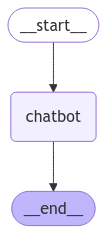

In [ ]:
from IPython.display import Image
graph = graph_builder.compile()
Image(graph.get_graph().draw_mermaid_png())

Now let's run the chatbot!

Since the state updates are always deserialized into LangChain Messages when using ```add_messages```, you should use dot notation to access message attributes, like:

```python
state["messages"][-1].content
```

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! 👋  How can I help you today? 😊
Assistant: My name is Gemma, I am an AI assistant. Nice to meet you, Manuel! 😊  What can I do for you today?
Assistant: As an AI, I have no memory of past conversations and do not know your name. If you'd like to tell me your name, I'd be happy to use it! 😊  

What's your name?
Goodbye!


## Part 2: 🛠️ Enhancing the Chatbot with web search tool. 

Tavily's Search API is a search engine built specifically for AI agents (LLMs), delivering real-time, accurate, and factual results at speed.

In [ ]:
# %%capture --no-stderr
# %pip install -U tavily-python langchain_community

In [17]:
from langchain_community.tools.tavily_search import TavilySearchResults
# os.environ["TAVILY_API_KEY"]

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

In [29]:
graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = gpt_model.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a ```BasicToolNode``` that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

In [24]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
            print(f"{message=}")
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the conditional_edges:
* If you want to optionally **route** to 1 or more edges (or optionally terminate), you can use the add_conditional_edges method. This method accepts the name of a node and a ```routing_function``` to call after that node is executed. 

* By default, the return value ```routing_function``` is used as the name of the node (or a list of nodes) to send the state to next. All those nodes will be run in parallel as a part of the next superstep.
* You can optionally provide a dictionary that maps the ```routing_function``` output to the name of the next node.

* If the condition can return ```END```, we don't need to explicitly set a **finish_point** this time. Our graph already has a way to finish!

In [25]:
def route_tools(state: State,):
    """Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

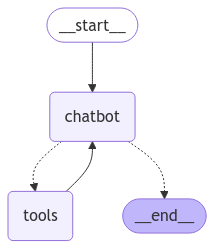

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph and about LlamaIndex?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        
        break


Assistant: 
message=AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eGdknadPnMG4LSbUAg1McVSg', 'function': {'arguments': '{"query": "LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_YwuTmx6IzUwmlCALoKNeL6Ub', 'function': {'arguments': '{"query": "llamaindex"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 90, 'total_tokens': 146, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-334aa777-a9df-448d-af84-597cc3eec9af-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_eGdknadPnMG4LSbUAg1

![alt](resources/route_tools.png)

## Part 3: Adding Memory to the Chatbot

If you provide a **checkpointer** when compiling the graph and a **thread_id** when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.

To get started, create a MemorySaver checkpointer.

In [33]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Next define the graph. Now that you've already built your own BasicToolNode, we'll replace it with LangGraph's prebuilt ```ToolNode``` and ```tools_condition```, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [34]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = gpt_model.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

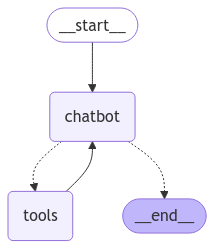

In [35]:
graph = graph_builder.compile(checkpointer=memory)
Image(graph.get_graph().draw_mermaid_png())

In [37]:
config = {"configurable": {"thread_id": "1"}}

In [38]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! How can I assist you today?


In [42]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Will! How can I help you today?


In [43]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='f5a19865-9390-4620-aeb6-5901c65a6e25'), AIMessage(content='Hi Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 87, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-13da1a7d-3611-4816-88bf-d91c19c56489-0', usage_metadata={'input_tokens': 87, 'output_tokens': 12, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, r

In [44]:
# The snapshot above contains the current state values, corresponding config, and the next node to process. In our case, the graph has reached an END state, so next is empty.
snapshot.next 

()

## Part 6: Customizing State

We'll create a passthrough "human" node, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. For our convenience, we will include an "ask_human" flag in our graph state that we will flip if the LLM calls this tool.



In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

Next, define a schema to show the model to let it decide to request assistance.

In [49]:
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [50]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = gpt_model.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [125]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

Next, create the "human" node. This node function is mostly a placeholder in our graph that will trigger an interrupt. If the human does not manually update the state during the interrupt, it inserts a tool message so the LLM knows the user was requested but didn't respond. This node also unsets the ask_human flag so the graph knows not to revisit the node unless further requests are made.

In [126]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        # we will use the same tool call id to link the response to the request
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

# we will interrupt the execution before this node, but if the user does not respond, we will include a placeholder ToolMessage to let the LLM continue


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
        print("No response from human.")
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

Next, define the conditional logic. The select_next_node will route to the human node if the flag is set. Otherwise, it lets the prebuilt tools_condition function choose the next node.

Recall that the tools_condition function simply checks to see if the chatbot has responded with any tool_calls in its response message. If so, it routes to the action node. Otherwise, it ends the graph.

In [127]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

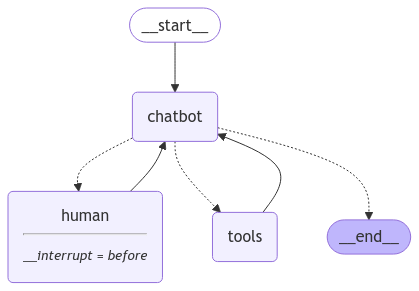

In [128]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

Image(graph.get_graph().draw_mermaid_png())

In [129]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_KBY0zeETmfAgyoW1KD80ezAF)
 Call ID: call_KBY0zeETmfAgyoW1KD80ezAF
  Args:
    request: I need expert guidance for building an AI agent. I'm looking for advice on the best practices, tools, and frameworks to use, as well as any potential challenges I might face during the development process.


In [130]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [131]:
snapshot.values["messages"][-1].tool_calls#[0]["args"]["request"]



[{'name': 'RequestAssistance',
  'args': {'request': "I need expert guidance for building an AI agent. I'm looking for advice on the best practices, tools, and frameworks to use, as well as any potential challenges I might face during the development process."},
  'id': 'call_KBY0zeETmfAgyoW1KD80ezAF',
  'type': 'tool_call'}]

Update status (reflects human response)

In [132]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message], "ask_human": True, })

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcd2f0-5263-6840-8002-1750a5e09d5d'}}

In [133]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='841741c9-b5e5-4b8e-8f67-4351df08e477'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KBY0zeETmfAgyoW1KD80ezAF', 'function': {'arguments': '{"request":"I need expert guidance for building an AI agent. I\'m looking for advice on the best practices, tools, and frameworks to use, as well as any potential challenges I might face during the development process."}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 160, 'total_tokens': 215, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0a

In [134]:
graph.get_state(config).next


('human',)

Now, resume the graph by invoking it with None as the inputs.

In [135]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I've requested expert guidance for you. They recommend using LangGraph to build your AI agent, as it is more reliable and extensible compared to simple autonomous agents. If you have any specific questions or need further assistance, feel free to ask!


In [137]:
graph.get_state(config).values["messages"]


[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='841741c9-b5e5-4b8e-8f67-4351df08e477'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KBY0zeETmfAgyoW1KD80ezAF', 'function': {'arguments': '{"request":"I need expert guidance for building an AI agent. I\'m looking for advice on the best practices, tools, and frameworks to use, as well as any potential challenges I might face during the development process."}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 160, 'total_tokens': 215, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0a

## Part 7: Time Travel
In this section, you will "rewind" your graph by fetching a checkpoint using the graph's get_state_history method. You can then resume execution at this previous point in time.

In [143]:
[a for a in graph.get_state_history(config)]



[StateSnapshot(values={'messages': [HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='841741c9-b5e5-4b8e-8f67-4351df08e477'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KBY0zeETmfAgyoW1KD80ezAF', 'function': {'arguments': '{"request":"I need expert guidance for building an AI agent. I\'m looking for advice on the best practices, tools, and frameworks to use, as well as any potential challenges I might face during the development process."}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 160, 'total_tokens': 215, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07

In [145]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 3:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('human',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('human',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [147]:
print(to_replay.next)
print(to_replay.config)
to_replay.values["messages"]

('human',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efcd2f0-5263-6840-8002-1750a5e09d5d'}}


[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='841741c9-b5e5-4b8e-8f67-4351df08e477'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KBY0zeETmfAgyoW1KD80ezAF', 'function': {'arguments': '{"request":"I need expert guidance for building an AI agent. I\'m looking for advice on the best practices, tools, and frameworks to use, as well as any potential challenges I might face during the development process."}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 160, 'total_tokens': 215, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0a

In [148]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I've reached out for expert guidance, and they recommend using **LangGraph** for building your AI agent. It's considered more reliable and extensible compared to simpler autonomous agents. If you have any specific questions or need further assistance, feel free to ask!


The Ai message is a bit diferent from the previous answer.